In [1]:
import numpy as np
import scipy as sp
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import heapq
from itertools import product
from functools import partial
import logging
import sympy as sym
smx,smy,smz=sym.symbols('x y z')

In [2]:
class GridHex:
    """
    >>> GridHex(np.linspce(0,1,11)) # for 1D
    >>> GridHex(np.linspce(0,1,11),np.linspce(0,1,21)) # for 2D
    >>> GridHex(np.linspce(0,1,11),np.linspce(0,1,21),np.linspce(0,1,31)) #for 3D
    """
    def __init__(self,*seeds,chs=2): 
        self.ndim=len(seeds)
        self.shape=tuple(len(seeds[axis]) for axis in range(self.ndim))
        self.seeds=[seeds[axis] for axis in range(self.ndim)]
        
        self.XYZs=np.meshgrid(*seeds,indexing='ij') # little different to meshgrid
        self.X,self.Y,self.Z=[self.XYZs[i] if self.ndim>i else None for i in range(3)]
        self.xs,self.ys,self.zs=[seeds[i] if self.ndim>i else None for i in range(3)]
        
        self.chs=chs
        self.funcs={
            0: self.upwindENO2,
            1: self.upwind,
            2: self.upwindENO2,
            3: self.upwindENO3,
        }

    def mesh_derivate(self):
        X,Y=self.X,self.Y
        m,n=np.shape(X)
        #print(m,n)
        dNjdxi=np.zeros((m-1,n-1,4,2,4))
        weights=np.zeros((m-1,n-1,4))
        for i in range(m-1):
            for j in range(n-1):
                nodes=((i,j),(i,j+1),(i+1,j+1),(i+1,j))
                coords=[(X[k,l],Y[k,l]) for (k,l) in nodes]
                dNjdris=isoparametric2d(coords)
                Js=dNjdris@np.array(coords)
                for k in range(4):
                    ni,nj=nodes[k]
                    J=Js[k,:,:]
                    dNjdxi[i,j,k,:,:]=np.linalg.inv(J)@(dNjdris[k,:,:])
                    weights[i,j,k]=1./np.linalg.det(J)
        return dNjdxi,weights
        
    def grad(self,Z):
        xs,ys=self.xs,self.ys
        fy,fx=np.gradient(Z,ys,xs)
        return np.array([fx,fy])
    
    def grad1(self,Z,mesh_der=None):
        """
        与np.gradient性能有较大差距，但是结果与其类似，不建议使用
        """
        X,Y=self.X,self.Y
        M,N=np.shape(X)
        der,wgh=np.zeros((2,M,N)),np.zeros((M,N))

        dNjdxis,weights=mesh_derivate(xx,yy) if mesh_der is None else mesh_der

        for i in range(M-1):
            for j in range(N-1):
                nodes=((i,j),(i,j+1),(i+1,j+1),(i+1,j))
                fs=[Z[k,l] for k,l in nodes]
                for k in range(4):
                    ni,nj=nodes[k]
                    dNjdxi=dNjdxis[i,j,k,:,:]
                    w=weights[i,j,k]
                    der[:,ni,nj]+=w*(dNjdxi@fs)
                    wgh[ni,nj]+=w
        der=der/wgh
        return der,wgh
    
    def plot(self,Z,title=''):
        if self.ndim==1:
            plt.plot(self.X,Z)
        elif self.ndim==2:
            plt.contourf(self.X,self.Y,Z)
            plt.colorbar()
        elif self.ndim==3:
            raise NotImplementedError("Unsupport 3D plot Now! ")
            pass
        plt.title(title)
        return 
    
    def __call__(self,axis,Z):
        return self.funcs[self.chs](axis,Z)
        
    def upwind(self,axis,Z):
        """
        used in upwind scheme.
        At each grid point, define φx− as D−φ and φx+ as D+φ. 
        If u_i > 0, approximate φx with φ−x . 
        If u_i < 0, approximate φx with φ+x .
        """
        xys=self.seeds
        triml1=tuple((slice(None) if i!=axis else slice(1,None) for i in range(ndim)))
        trimr1=tuple((slice(None) if i!=axis else slice(0,-1) for i in range(ndim)))        
        extd=tuple((None if i!=axis else slice(None) for i in range(ndim)))
        
        gc=GhostCell(stencil=1)
        dxy1=gc.periodic(axis,np.diff(xys[axis])[extd])
        
        D0=gc.periodic(axis,Z)
        D1=np.diff(D0,axis=axis)/dxy1

        Dlft,Drht=D1[trimr1],D1[triml1]

        return Dlft,Drht
    
    def upwindENO2(self,axis,Z,subcellfix=False):
        """
        Give second order approximation for One-Sided Derivatives φx− and φx+ 
        there are two possible second order approximations to both the left and right, 
        and  chooses the least oscillatory one according to the 
        
        Refer to:
            1. Osher S, Fedkiw R, Piechor K. Level set methods and dynamic implicit surfaces[J]. Appl. Mech. Rev., 2004, 57(3): B15-B15.
                Chapter 3.3 Hamilton-Jacobi ENO
            2. Mitchell I M. A toolbox of level set methods[J]. UBC Department of Computer Science Technical Report TR-2007-11, 2007.
                upwindFirstENO2.m
                
        Parameters
        __________
        axis : the dimension axis index; 0 means axis 0 , 1 means axis 1
        Z   : function values matrix

        """
        xys,ndim=self.seeds,self.ndim
        
        triml1=tuple((slice(None) if i!=axis else slice(1,None) for i in range(ndim)))
        triml2=tuple((slice(None) if i!=axis else slice(2,None) for i in range(ndim)))
        trimr1=tuple((slice(None) if i!=axis else slice(0,-1) for i in range(ndim)))
        trimr2=tuple((slice(None) if i!=axis else slice(0,-2) for i in range(ndim)))
        trimlr1=tuple((slice(None) if i!=axis else slice(1,-1) for i in range(ndim)))
        extd=tuple((None if i!=axis else slice(None) for i in range(ndim)))
        
        gc2=GhostCell(stencil=2)
        dxy1=gc2.zeroOrderExtrapolation(axis,np.diff(xys[axis])[extd])
        D0=gc2.zeroOrderExtrapolation(axis,Z)#gc2.periodic(axis,Z)
        D1=np.diff(D0,axis=axis)/dxy1
        D2=(D1[triml1]-D1[trimr1])/(dxy1[triml1]+dxy1[trimr1]) # N+2
        
        D1,dxy1=D1[trimlr1],dxy1[trimlr1] # N+1
        D2abs=np.abs(D2) 
        
        # when using second order Newton polynomial interpolation
        #  φ− can be defined from two cases : (i-2,i-1,i) or (i-1,i,i+1)
        #  φ+ can be defined from two cases : (i-1,i,i+1) or (i,i+1,i+2)
        #  According to Ref.1, Choose the one with smaller absolute value which can avoid interpolating near large variations such as discontinuities or steep gradients
        Dlft=D1[trimr1]+dxy1[trimr1]*np.where(D2abs[trimr2]<D2abs[trimlr1],D2[trimr2],D2[trimlr1])
        Drht=D1[triml1]-dxy1[triml1]*np.where(D2abs[trimlr1]<D2abs[triml2],D2[trimlr1],D2[triml2])
        return Dlft,Drht
    
    def upwindENO3(self,axis,Z):
        raise NotImplementedError('Uowind ENO 3 not implemented error!')
    
    def finite_difference(self,axis,Z,index):
        """
        return the first order and second order finite difference of the index of `Z` in the direction of `axis`
        """
        pass
    def coord(self,ptindex):
        return [seed[ind] for seed,ind in zip(self.seeds,ptindex)]
    
class GhostCell:
    """
    Chapter 7 Boundary Conditions and Ghost Cells from 
        LeVeque R J. Finite volume methods for hyperbolic problems[M]. Cambridge university press, 2002.
        
        https://github.com/clawpack/classic/blob/master/src/1d/bc1.f
    >>> X=np.np.linspace(0,23,24).reshape((2,3,4))
    >>> GhostCell(2).zeroOrderExtrapolation(1,X)
    """
    def __init__(self,stencil=1,scale=1.0):
        self.stencil=stencil
        self.scale=scale
        
    def periodic(self,axis,X):
        stencil=self.stencil
        slc1=tuple(slice(None) if i!=axis else slice(-stencil,None) for i in range(X.ndim))
        slc2=tuple(slice(None) if i!=axis else slice(stencil) for i in range(X.ndim))
        return np.concatenate((X[slc1]*self.scale,X,X[slc2]*self.scale),axis=axis)
    
    def zeroOrderExtrapolation(self,axis,X):
        stencil=self.stencil
        slc1=tuple(slice(None) if i!=axis else slice(0,1) for i in range(X.ndim))
        slc2=tuple(slice(None) if i!=axis else slice(-1,None) for i in range(X.ndim))
        
        X0=np.repeat(X[slc1],stencil,axis=axis)*self.scale
        X1=np.repeat(X[slc2],stencil,axis=axis)*self.scale
        
        #print(X0.shape,X1.shape,X.shape)
        return np.concatenate((X0,X,X1),axis=axis)

In [422]:
VoxelPointOrder={
    1:[(0,),(1,)],
    2:[(0,0),(0,1),(1,0),(1,1)],
    3:[(0, 0, 0),(0, 0, 1),(0, 1, 0),(0, 1, 1),
       (1, 0, 0),(1, 0, 1),(1, 1, 0),(1, 1, 1)],
}
VoxelPointOrder={
    1:[(0,),(1,)],
    # Figure 3.6.1 in Numerical recips
    2:[(0,0),(1,0),(1,1),(0,1)], 
    # 
    3:[(0,0,0),(1,0,0),(1,1,0),(0,1,0),
       (0,0,1),(1,0,1),(1,1,1),(0,1,1),],
}

p=lambda x,k: 0 if k<0 else x**k

X1=np.zeros((4,4))
for k,(x,) in enumerate(VoxelPointOrder[1]):
    X1[k,:]=np.array([p(x,i) for i in range(4)])
    X1[k+2,:]=np.array([i*p(x,i-1) for i in range(4)])
W1=np.linalg.inv(X1)

X2=np.zeros((16,16))
for k,(x,y) in enumerate(VoxelPointOrder[2]):
    X2[k,:]=np.array([p(x,i)*p(y,j) for i,j in product(range(4),range(4))])
    X2[k+4,:]=np.array([i*p(x,i-1)*p(y,j) for i,j in product(range(4),range(4))])
    X2[k+8,:]=np.array([j*p(x,i)*p(y,j-1) for i,j in product(range(4),range(4))])
    X2[k+12,:]=np.array([i*j*p(x,i-1)*p(y,j-1) for i,j in product(range(4),range(4))])
W2=np.linalg.inv(X2) 

X3=np.zeros((64,64))
for n,(x,y,z) in enumerate(VoxelPointOrder[3]):
    X3[n,:]   =np.array([p(x,i)*p(y,j)*p(z,k) for i,j,k in product(range(4),range(4),range(4))])
    X3[n+8,:] =np.array([i*p(x,i-1)*p(y,j)*p(z,k) for i,j,k in product(range(4),range(4),range(4))])
    X3[n+16,:]=np.array([j*p(x,i)*p(y,j-1)*p(z,k) for i,j,k in product(range(4),range(4),range(4))])
    X3[n+24,:]=np.array([k*p(x,i)*p(y,j)*p(z,k-1) for i,j,k in product(range(4),range(4),range(4))])
    X3[n+32,:]=np.array([k*j*p(x,i)*p(y,j-1)*p(z,k-1) for i,j,k in product(range(4),range(4),range(4))])    
    X3[n+40,:]=np.array([i*k*p(x,i-1)*p(y,j)*p(z,k-1) for i,j,k in product(range(4),range(4),range(4))])
    X3[n+48,:]=np.array([i*j*p(x,i-1)*p(y,j-1)*p(z,k) for i,j,k in product(range(4),range(4),range(4))])
    X3[n+56,:]=np.array([i*j*k*p(x,i-1)*p(y,j-1)*p(z,k-1) for i,j,k in product(range(4),range(4),range(4))])
W3=np.linalg.inv(X3)
np.savetxt('W1_4x4.txt',W1.flatten('F').astype(np.int),fmt='%d', delimiter=',',newline='\n')
np.savetxt('W2_16x16.txt',W2.flatten('F').astype(np.int),fmt='%d', delimiter=',',newline='\n')
np.savetxt('W3_64x64.txt',W3.flatten('F').astype(np.int),fmt='%d', delimiter=',',newline='\n')
#W1.flatten(order='F'),W2.flatten(order='F'),W3.flatten(order='F')

def cucof(ys,y1s,ds,W=None):
    """
    ys,y1s : the value of f,f_x in grid points (0,0),(0,1),(1,0),(1,1)
    d1 : the length of the 1th and 2th dimension
    """
    d1=ds[0]
    x=np.concatenate([ys,y1s*d1])
    c=np.dot(W,x).reshape((4,),order='C')
    return c
cucof=partial(cucof,W=W1)
def cuint(c,seeds,xs):
    x=xs[0]
    d1=seeds[0][1]-seeds[0][0]
    t=(x-seeds[0][0])/d1
    y=((c[3]*t+c[2])*t+c[1])*t+c[0]
    y1=(3*c[3]*t+2*c[2])*t+c[1]
    return y,(y1/d1,)

# Press W H, Teukolsky S A, Flannery B P, et al. Numerical recipes in Fortran 77: volume 1, volume 1 of Fortran numerical recipes: the art of scientific computing[M]. Cambridge university press, 1992.
def bcucof(ys,y1s,y2s,y12s,ds,W=None):
    """
    ys,y1s,y2s,y12s : the value of f,f_x,f_y,f_xy in grid points (0,0),(0,1),(1,0),(1,1)
    d1,d2 : the length of the 1th and 2th dimension
    """
    d1,d2=ds
    x=np.concatenate([ys,y1s*d1,y2s*d2,y12s*(d1*d2)])
    c=np.dot(W,x).reshape((4,4),order='C')
    return c
bcucof=partial(bcucof,W=W2)

def bcuint(c,seeds,xs):
    d1,d2=[seed[1]-seed[0] for seed in seeds]
    t,u=[(xs[i]-seeds[i][0])/(seeds[i][1]-seeds[i][0]) for i in range(2)]

    y,y1,y2=0.,0.,0.
    for i in range(3,-1,-1):
        y=t*y+((c[i,3]*u+c[i,2])*u+c[i,1])*u+c[i,0]
        y1=u*y1+(3*c[3,i]*t+2*c[2,i])*t+c[1,i]
        y2=t*y2+(3*c[i,3]*u+2*c[i,2])*u+c[i,1]
    return y,(y1/d1,y2/d2)

def tricucof(ys,y1s,y2s,y3s,y23s,y13s,y12s,y123s,ds,W=None):
    d1,d2,d3=ds
    x=np.concatenate([ys,y1s*d1,y2s*d2,y3s*d3,
                      y23s*(d2*d3),y13s*(d1*d3),y12s*(d1*d2),
                      y123s*(d1*d2*d3)])
    c=np.dot(W,x).reshape((4,4,4),order='C')
    return c
tricucof=partial(tricucof,W=W3)

def tricuint(c,seeds,xs):
    """
    seeds: tuple of lower bound and upper bound of axis
        ((x1l,x1u),(x2l,x2u),(x3l,x3u))
    """
    d1,d2,d3=[seeds[i][1]-seeds[i][0] for i in range(3)]
    r,s,t=[(xs[i]-seeds[i][0])/(seeds[i][1]-seeds[i][0]) for i in range(3)]
    #print(c)
    
    y,y1,y2,y3=0.,0.,0.,0.
    for i in range(3,-1,-1):
        inc,inc1,inc2,inc3=0.,0.,0.,0.
        for j in range(3,-1,-1):
            inc=t*inc+((c[i,3,j]*s+c[i,2,j])*s+c[i,1,j])*s+c[i,0,j]
            inc1=s*inc1+(3*c[3,j,i]*r+2*c[2,j,i])*r+c[1,j,i]
            inc2=t*inc2+(3*c[i,3,j]*s+2*c[i,2,j])*s+c[i,1,j]
            inc3=r*inc3+(3*c[j,i,3]*t+2*c[j,i,2])*t+c[j,i,1]
        y=r*y+inc
        y1=t*y1+inc1
        y2=r*y2+inc2
        y3=s*y3+inc3
    return y,(y1/d1,y2/d2,y3/d3)

class GridHex:
    """
    >>> GridHex(np.linspce(0,1,11)) # for 1D
    >>> GridHex(np.linspce(0,1,11),np.linspce(0,1,21)) # for 2D
    >>> GridHex(np.linspce(0,1,11),np.linspce(0,1,21),np.linspce(0,1,31)) #for 3D
    """
    def __init__(self,*seeds,chs=2): 
        self.ndim=len(seeds)
        self.shape=tuple(len(seeds[axis]) for axis in range(self.ndim))
        self.seeds=[seeds[axis] for axis in range(self.ndim)]
        
        self.XYZs=np.meshgrid(*seeds,indexing='ij') # little different to meshgrid
        self.X,self.Y,self.Z=[self.XYZs[i] if self.ndim>i else None for i in range(3)]
        self.xs,self.ys,self.zs=[seeds[i] if self.ndim>i else None for i in range(3)]
        
        self.chs=chs
        self.funcs={
            0: self.upwindENO2,
            1: self.upwind,
            2: self.upwindENO2,
            3: self.upwindENO3,
        }

    def mesh_derivate(self):
        X,Y=self.X,self.Y
        m,n=np.shape(X)
        #print(m,n)
        dNjdxi=np.zeros((m-1,n-1,4,2,4))
        weights=np.zeros((m-1,n-1,4))
        for i in range(m-1):
            for j in range(n-1):
                nodes=((i,j),(i,j+1),(i+1,j+1),(i+1,j))
                coords=[(X[k,l],Y[k,l]) for (k,l) in nodes]
                dNjdris=isoparametric2d(coords)
                Js=dNjdris@np.array(coords)
                for k in range(4):
                    ni,nj=nodes[k]
                    J=Js[k,:,:]
                    dNjdxi[i,j,k,:,:]=np.linalg.inv(J)@(dNjdris[k,:,:])
                    weights[i,j,k]=1./np.linalg.det(J)
        return dNjdxi,weights
        
    def grad(self,Z):
        xs,ys=self.xs,self.ys
        fy,fx=np.gradient(Z,ys,xs)
        return np.array([fx,fy])
    
    def grad1(self,Z,mesh_der=None):
        """
        与np.gradient性能有较大差距，但是结果与其类似，不建议使用
        """
        X,Y=self.X,self.Y
        M,N=np.shape(X)
        der,wgh=np.zeros((2,M,N)),np.zeros((M,N))

        dNjdxis,weights=mesh_derivate(xx,yy) if mesh_der is None else mesh_der

        for i in range(M-1):
            for j in range(N-1):
                nodes=((i,j),(i,j+1),(i+1,j+1),(i+1,j))
                fs=[Z[k,l] for k,l in nodes]
                for k in range(4):
                    ni,nj=nodes[k]
                    dNjdxi=dNjdxis[i,j,k,:,:]
                    w=weights[i,j,k]
                    der[:,ni,nj]+=w*(dNjdxi@fs)
                    wgh[ni,nj]+=w
        der=der/wgh
        return der,wgh
    
    def plot(self,Z,title=''):
        if self.ndim==1:
            plt.plot(self.X,Z)
        elif self.ndim==2:
            plt.contourf(self.X,self.Y,Z)
            plt.colorbar()
        elif self.ndim==3:
            raise NotImplementedError("Unsupport 3D plot Now! ")
            pass
        plt.title(title)
        return 
    
    def __call__(self,axis,Z):
        return self.funcs[self.chs](axis,Z)
        
    def upwind(self,axis,Z):
        """
        used in upwind scheme.
        At each grid point, define φx− as D−φ and φx+ as D+φ. 
        If u_i > 0, approximate φx with φ−x . 
        If u_i < 0, approximate φx with φ+x .
        """
        xys=self.seeds
        triml1=tuple((slice(None) if i!=axis else slice(1,None) for i in range(ndim)))
        trimr1=tuple((slice(None) if i!=axis else slice(0,-1) for i in range(ndim)))        
        extd=tuple((None if i!=axis else slice(None) for i in range(ndim)))
        
        gc=GhostCell(stencil=1)
        dxy1=gc.periodic(axis,np.diff(xys[axis])[extd])
        
        D0=gc.periodic(axis,Z)
        D1=np.diff(D0,axis=axis)/dxy1

        Dlft,Drht=D1[trimr1],D1[triml1]

        return Dlft,Drht
    
    def upwindENO2(self,axis,Z,subcellfix=False):
        """
        Give second order approximation for One-Sided Derivatives φx− and φx+ 
        there are two possible second order approximations to both the left and right, 
        and  chooses the least oscillatory one according to the 
        
        Refer to:
            1. Osher S, Fedkiw R, Piechor K. Level set methods and dynamic implicit surfaces[J]. Appl. Mech. Rev., 2004, 57(3): B15-B15.
                Chapter 3.3 Hamilton-Jacobi ENO
            2. Mitchell I M. A toolbox of level set methods[J]. UBC Department of Computer Science Technical Report TR-2007-11, 2007.
                upwindFirstENO2.m
                
        Parameters
        __________
        axis : the dimension axis index; 0 means axis 0 , 1 means axis 1
        Z   : function values matrix

        """
        xys,ndim=self.seeds,self.ndim
        
        triml1=tuple((slice(None) if i!=axis else slice(1,None) for i in range(ndim)))
        triml2=tuple((slice(None) if i!=axis else slice(2,None) for i in range(ndim)))
        trimr1=tuple((slice(None) if i!=axis else slice(0,-1) for i in range(ndim)))
        trimr2=tuple((slice(None) if i!=axis else slice(0,-2) for i in range(ndim)))
        trimlr1=tuple((slice(None) if i!=axis else slice(1,-1) for i in range(ndim)))
        extd=tuple((None if i!=axis else slice(None) for i in range(ndim)))
        
        gc2=GhostCell(stencil=2)
        dxy1=gc2.zeroOrderExtrapolation(axis,np.diff(xys[axis])[extd])
        D0=gc2.zeroOrderExtrapolation(axis,Z)#gc2.periodic(axis,Z)
        D1=np.diff(D0,axis=axis)/dxy1
        D2=(D1[triml1]-D1[trimr1])/(dxy1[triml1]+dxy1[trimr1]) # N+2
        
        D1,dxy1=D1[trimlr1],dxy1[trimlr1] # N+1
        D2abs=np.abs(D2) 
        
        # when using second order Newton polynomial interpolation
        #  φ− can be defined from two cases : (i-2,i-1,i) or (i-1,i,i+1)
        #  φ+ can be defined from two cases : (i-1,i,i+1) or (i,i+1,i+2)
        #  According to Ref.1, Choose the one with smaller absolute value which can avoid interpolating near large variations such as discontinuities or steep gradients
        Dlft=D1[trimr1]+dxy1[trimr1]*np.where(D2abs[trimr2]<D2abs[trimlr1],D2[trimr2],D2[trimlr1])
        Drht=D1[triml1]-dxy1[triml1]*np.where(D2abs[trimlr1]<D2abs[triml2],D2[trimlr1],D2[triml2])
        return Dlft,Drht
    
    def upwindENO3(self,axis,Z):
        raise NotImplementedError('Uowind ENO 3 not implemented error!')
    
    def finite_difference(self,axis,Z,index):
        """
        return the first order and second order finite difference of the index of `Z` in the direction of `axis`
        """
        pass
    
    
    def isSignChange(self,vindex,X):
        """
        whether if there is sign change in the voxcel
        """
        #考虑浮点数误差
        vals=X[tuple(slice(ind,ind+2) for ind in vindex)].flatten()
        return np.abs(np.mean(np.where(np.abs(vals)>1e-13,
                                       np.sign(vals),0)
                             ))!=1
    def isPoint(self,ptindex):
        """
        返回节点是否是内部节点
        """
        return all(0<=ind<l for l,ind in zip(self.shape,ptindex))

    def coord(self,ptindex):
        return [seed[ind] for seed,ind in zip(self.seeds,ptindex)]

    def neighbours(self,index):
        """
        返回邻接节点的索引列表
        """
        ndim=self.ndim
        return [tuple((index[k]+j*(k==i) for k in range(ndim))) 
                        for i in range(ndim) for j in (-1,1) 
                        if 0<=index[i]+j<self.shape[i]]

    def adjacent(self,ptindex,axis,N=1):
        """
        返回 沿axis方向左右两侧与节点index相邻的N个节点的列表的列表
        
        """
        ndim=self.ndim
        
        pts=[[tuple([ptindex[k]-i*(k==axis) for k in range(ndim)]) for i in range(1,N+1)],
             [tuple([ptindex[k]+i*(k==axis) for k in range(ndim)]) for i in range(1,N+1)]]
        return pts

    def delta(self,index,axis):
        """
        计算节点index 沿着axis方向的长度
        """
        seed=self.seeds[axis]
        ind=index[axis] #min(max(index[axis],0),self.grid.X.shape[axis]-2)
        if (ind>=0) and (ind<=len(seed)-2):
            return seed[ind+1]-seed[axis][ind]
        else:
            return (seed[-1]-seed[0])*1E4

    def voxelPoints(self,vindex):
        """
        return a list of index of the grid points of voxel `vindex`
        """
        ndim=self.ndim
        return [tuple(vindex[i]+pt[i] for i in range(ndim)) 
                    for pt in VoxelPointOrder[ndim] ]
    
    def voxelBound(self,vindex):
        return [(seed[ind],seed[ind+1]) for seed,ind in zip(self.seeds,vindex)]
    
    def voxelValues(self,vindex,X):
        """
        return multi dimension array of values 
        """
        return X[tuple(slice(ind,ind+2) for ind in vindex)]
    
    def triVoxelValues(self,vindex,X):
        return np.array([X[ptindex] for ptindex in self.voxelPoints(vindex)])
    
    def flatten(self,X):
        """
        flatten a multi dimension array `X` in the order defined in `VoxelPointOder`
        """
        return np.array([X[pt] for pt in VoxelPointOrder[self.ndim]])
    
    def gradient(self,X,index):
        seeds=self.seeds
        g=np.zeros((self.ndim,))
        for axis in range(self.ndim):
            seed=seeds[axis]
            ind=index[axis]
            f0=X[index]
            if ind==0:
                dx2=seed[ind+1]-seed[ind]
                fr=X[tuple(index[i]+1*(i==axis) for i in range(self.ndim))]
                d=(fr-f0)/dx2
            elif ind==self.shape[axis]-1:
                dx1=seed[ind]-seed[ind-1]
                fl=X[tuple(index[i]-1*(i==axis) for i in range(self.ndim))]
                d=(f0-fl)/dx1
            else:
                dx1=seed[ind]-seed[ind-1]
                fl=X[tuple(index[i]-1*(i==axis) for i in range(self.ndim))]
                dx2=seed[ind+1]-seed[ind]
                fr=X[tuple(index[i]+1*(i==axis) for i in range(self.ndim))]
                d=-(dx2)/(dx1*(dx1 + dx2))*fl+(dx2 - dx1)/(dx1 * dx2)*f0+dx1 / (dx2 * (dx1 + dx2))*fr
            g[axis]=d
        return g
    def cubicCoff(self,vindex,X):
        """
        Using Bicubic or Tricubic Interpolation to Calculate The distance of nodes in those elements which the zero level set crosses 
        1. Chopp D L. Some improvements of the fast marching method[J]. SIAM Journal on Scientific Computing, 2001, 23(1): 230-244.
            Section 3.2
        2. Sukumar N, Chopp D L, Béchet E, et al. Three‐dimensional non‐planar crack growth by a coupled extended finite element and fast marching method[J]. International journal for numerical methods in engineering, 2008, 76(5): 727-748.
            Section 3.1.1 
        """
        grid=self
        ndim=grid.ndim
        oneOrder=lambda dx1,dx2: (-(dx2)/(dx1 * (dx1 + dx2)),(dx2 - dx1) / (dx1 * dx2),dx1 / (dx2 * (dx1 + dx2)))
        
        if ndim==1:
            # ys,y1s
            vals=np.array([X[i] for i in 
                           (max(0,min(j,grid.shape[0]-1)) for j in range(vindex[0]-1,vindex[0]+3))])
            ds=np.array([grid.seeds[0][j+1]-grid.seeds[0][j] for j in 
                         (max(0,min(i,grid.shape[0]-2)) for i in range(vindex[0]-1,vindex[0]+2))])
            ys=vals[1:3]
            y1s=np.zeros((2,))
            for i in range(1,3):
                a,b,c=oneOrder(ds[i-1],ds[i])
                y1s[i-1]=a*vals[i-1]+b*vals[i]+c*vals[i+1]
            return cucof(ys,y1s,[grid.seeds[i][vindex[i]+1]-grid.seeds[i][vindex[i]] for i in range(ndim)])
        elif ndim==2:
            #ys,y1s,y2s,y12s
            vals,ds=np.zeros((4,4)),np.zeros((2,3))
            ys=np.zeros((2,2))
            y1s,y2s=np.zeros((2,2)),np.zeros((2,2))
            y12s=np.zeros((2,2))
            
            for i in range(4):
                ind1=min(max(vindex[0]-1+i,0),grid.shape[0]-1)
                for j in range(4):
                    ind2=min(max(vindex[1]-1+j,0),grid.shape[1]-1)
                    vals[i,j]=X[ind1,ind2]
            for axis in range(2):
                for j in range(3):
                    ind=vindex[axis]-1+j
                    if ind<0 or ind>grid.shape[axis]-2:
                        ds[axis,j]=10000*(grid.seeds[axis][-1]-grid.seeds[axis][0])
                    else:
                        ds[axis,j]=grid.seeds[axis][ind+1]-grid.seeds[axis][ind]
            for i in range(1,3):
                dx1,dx0=ds[0,i],ds[0,i-1]
                for j in range(1,3):
                    dy1,dy0=ds[1,j],ds[1,j-1]
                    ys[i-1,j-1]=vals[i,j]
                    
                    a,b,c=oneOrder(dx0,dx1)
                    y1s[i-1,j-1]=a*vals[i-1,j]+b*vals[i,j]+c*vals[i+1,j]
                    a,b,c=oneOrder(dy0,dy1)
                    y2s[i-1,j-1]=a*vals[i,j-1]+b*vals[i,j]+c*vals[i,j+1]
                    
                    y12s[i-1,j-1]=(vals[i+1,j+1]-vals[i+1,j-1]-vals[i-1,j+1]+vals[i-1,j-1])/((dx0+dx1)*(dy1+dy0))
                    
            return bcucof(self.flatten(ys),self.flatten(y1s),self.flatten(y2s),self.flatten(y12s),
                         [grid.seeds[i][vindex[i]+1]-grid.seeds[i][vindex[i]] for i in range(ndim)])
        elif ndim==3:
            #ys,y1s,y2s,y3s,y12ss,y13s,y23s,y123s
            ys=np.zeros((2,2,2))
            y1s,y2s,y3s=np.zeros((2,2,2)),np.zeros((2,2,2)),np.zeros((2,2,2))
            y23s,y13s,y12s=np.zeros((2,2,2)),np.zeros((2,2,2)),np.zeros((2,2,2))
            y123s=np.zeros((2,2,2))
            
            vals=np.zeros((4,4,4))
            for idx in product(*[range(4) for i in range(ndim)]):
                vals[idx]=X[tuple(min(max(vindex[i]-1+idx[i],0),grid.shape[i]-1) for i in range(ndim))]
            
            ax_dx=[[],]*ndim
            for axis in range(ndim):
                ind=vindex[axis]
                for i in range(-1,2):
                    ind1=ind+i
                    if ind1<0 or ind1>grid.shape[axis]-2:
                        lth=10000*(grid.seeds[axis][-1]-grid.seeds[axis][1])
                    else:
                        lth=grid.seeds[axis][ind1+1]-grid.seeds[axis][ind1]
                    ax_dx[axis].append(lth)
                ax_dx[axis]=np.array(ax_dx[axis])
            
            for idx in product(*[range(2) for i in range(ndim)]):
                i,j,k=tuple(idx[l]+1 for l in range(ndim))
                ys[idx]=vals[i,j,k]
                ds=[(ax_dx[axis][idx[axis]],ax_dx[axis][idx[axis]+1]) for axis in range(ndim)]
                
                a,b,c=oneOrder(*ds[0])
                y1s[idx]=a*vals[i-1,j,k]+b*vals[i,j,k]+c*vals[i+1,j,k]
                a,b,c=oneOrder(*ds[1])
                y2s[idx]=a*vals[i,j-1,k]+b*vals[i,j,k]+c*vals[i,j+1,k]
                a,b,c=oneOrder(*ds[2])
                y3s[idx]=a*vals[i,j,k-1]+b*vals[i,j,k]+c*vals[i,j,k+1]
                
                a=(ds[1][0]+ds[1][1])*(ds[2][0]+ds[2][1])
                y23s[idx]=(vals[i,j+1,k+1]+vals[i,j-1,k-1]-vals[i,j+1,k-1]-vals[i,j-1,k+1])/a
                a=(ds[0][0]+ds[0][1])*(ds[2][0]+ds[2][1])
                y13s[idx]=(vals[i+1,j,k+1]+vals[i-1,j,k-1]-vals[i+1,j,k-1]-vals[i-1,j,k+1])/a
                a=(ds[1][0]+ds[1][1])*(ds[0][0]+ds[0][1])
                y12s[idx]=(vals[i+1,j+1,k]+vals[i-1,j-1,k]-vals[i-1,j+1,k]-vals[i+1,j-1,k])/a   
                
                a=(ds[0][0]+ds[0][1])*(ds[1][0]+ds[1][1])*(ds[2][0]+ds[2][1])
                y123s[idx]=((vals[i+1,j+1,k+1]+vals[i-1,j-1,k+1]-vals[i-1,j+1,k+1]-vals[i+1,j-1,k+1])-
                            (vals[i+1,j+1,k-1]+vals[i-1,j-1,k-1]-vals[i-1,j+1,k-1]-vals[i+1,j-1,k-1]))/a 
            return tricucof(self.flatten(ys),
                    self.flatten(y1s),self.flatten(y2s),self.flatten(y3s),
                    self.flatten(y23s),self.flatten(y13s),self.flatten(y12s),
                    self.flatten(y123s),
                    [grid.seeds[i][vindex[i]+1]-grid.seeds[i][vindex[i]] for i in range(ndim)])
        else:
            raise NotImplementedError('Cubic Interpolation for %d D Not Sumpport Now'%(ndim))

    def cubicInterpolation(self,cof,vindex,xs):
        """
        计算vindex中 xs对应的值和导数
        """
        ndim=self.ndim
        seeds=[(seed[ind],seed[ind+1]) for seed,ind in zip(self.seeds,vindex)]
        #seeds=[(self.seeds[i][vindex[i]],self.seeds[i][vindex[i]+1]) for i in range(ndim)]
        if ndim==1:
            return cuint(cof,seeds,xs)
        elif ndim==2:
            return bcuint(cof,seeds,xs)
        elif ndim==3:
            return tricuint(cof,seeds,xs)
        else:
            raise NotImplementedError('Cubic Interpolation for %d D Not Sumpport Now'%(ndim))        
    
class GhostCell:
    """
    Chapter 7 Boundary Conditions and Ghost Cells from 
        LeVeque R J. Finite volume methods for hyperbolic problems[M]. Cambridge university press, 2002.
        
        https://github.com/clawpack/classic/blob/master/src/1d/bc1.f
    >>> X=np.np.linspace(0,23,24).reshape((2,3,4))
    >>> GhostCell(2).zeroOrderExtrapolation(1,X)
    """
    def __init__(self,stencil=1,scale=1.0):
        self.stencil=stencil
        self.scale=scale
        
    def periodic(self,axis,X):
        stencil=self.stencil
        slc1=tuple(slice(None) if i!=axis else slice(-stencil,None) for i in range(X.ndim))
        slc2=tuple(slice(None) if i!=axis else slice(stencil) for i in range(X.ndim))
        return np.concatenate((X[slc1]*self.scale,X,X[slc2]*self.scale),axis=axis)
    
    def zeroOrderExtrapolation(self,axis,X):
        stencil=self.stencil
        slc1=tuple(slice(None) if i!=axis else slice(0,1) for i in range(X.ndim))
        slc2=tuple(slice(None) if i!=axis else slice(-1,None) for i in range(X.ndim))
        
        X0=np.repeat(X[slc1],stencil,axis=axis)*self.scale
        X1=np.repeat(X[slc2],stencil,axis=axis)*self.scale
        
        #print(X0.shape,X1.shape,X.shape)
        return np.concatenate((X0,X,X1),axis=axis)

In [423]:
gd2=GridHex(np.linspace(-1,1,101),np.linspace(-1,1,101))
Z=gd2.X**2+gd2.Y**3

In [ ]:
for i in range(0,10,2):
    for j in range(0,10,2):
        print(gd2.seeds[0][i]*2,3*gd2.seeds[1][j]**2,gd2.gradient(Z,(i,j)))

In [419]:
3*gd2.Y[(2,1)]**2

2.8811999999999998

In [420]:
(0.036864+0.0784)/0.02/2

2.8816

In [417]:
Z[1:4,0:3]

array([[-0.0396  ,  0.019208,  0.075664],
       [-0.0784  , -0.019592,  0.036864],
       [-0.1164  , -0.057592, -0.001136]])

In [406]:
gd2.X[:2,:2],gd2.Y[:2,:2]

(array([[-1.  , -1.  ],
        [-0.98, -0.98]]), array([[-1.  , -0.98],
        [-1.  , -0.98]]))

### 一维三次插值

In [5]:
W1.flatten('F')

array([ 1.,  0., -3.,  2.,  0.,  0.,  3., -2.,  0.,  1., -2.,  1.,  0.,
        0., -1.,  1.])

In [6]:
f=smx**3
#f1,f2,f3,f12,f13,f23,f123
fs=f,f.diff(smx)
seeds=((0.,1.),)

vals=list(zip(*[[expr.evalf(subs={'x':x}) for expr in fs] for x in seeds[0]]))
cof=cucof(*[np.array(val) for val in vals],(seeds[0][1]-seeds[0][0],))

In [7]:
xs=np.linspace(0,1,11)
[cuint(cof,seeds,(x,)) for x in xs]

[(0, (0,)),
 (0.00100000000000000, (0.0300000000000000,)),
 (0.00800000000000000, (0.120000000000000,)),
 (0.0270000000000000, (0.270000000000000,)),
 (0.0640000000000000, (0.480000000000000,)),
 (0.125000000000000, (0.750000000000000,)),
 (0.216000000000000, (1.08000000000000,)),
 (0.343000000000000, (1.47000000000000,)),
 (0.512000000000000, (1.92000000000000,)),
 (0.729000000000000, (2.43000000000000,)),
 (1.00000000000000, (3.00000000000000,))]

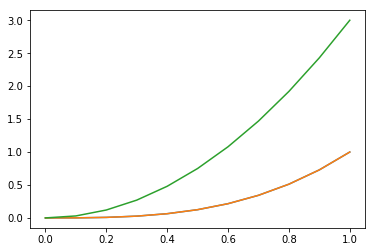

In [8]:
xs=np.linspace(0,1,11)
plt.plot(xs,[cuint(cof,seeds,(x,))[0] for x in xs])
plt.plot(xs,[fs[0].evalf(subs={'x':x}) for x in xs])
plt.plot(xs,[fs[1].evalf(subs={'x':x}) for x in xs])

### 二维三次插值

In [9]:
np.set_printoptions(linewidth=np.nan)
np.savetxt('W2_16x16.txt',W2.flatten('F').astype(np.int),fmt='%d', delimiter=',',newline='\n')
W2.flatten('F')

array([ 1.,  0., -3.,  2.,  0.,  0., -0.,  0., -3.,  0.,  9., -6.,  2.,  0., -6.,  4.,  0.,  0.,  3., -2.,  0.,  0., -0.,  0.,  0.,  0., -9.,  6., -0.,  0.,  6., -4.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  3.,  0., -9.,  6., -2.,  0.,  6., -4.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  9., -6., -0.,  0., -6.,  4.,  0.,  0., -0.,  0.,  1.,  0., -3.,  2., -2.,  0.,  6., -4.,  1.,  0., -3.,  2.,  0.,  0., -0.,  0.,  0.,  0.,  3., -2.,  0.,  0., -6.,  4., -0.,  0.,  3., -2.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -1.,  0.,  3., -2.,  1.,  0., -3.,  2.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -3.,  2., -0.,  0.,  3., -2.,  0.,  1., -2.,  1.,  0.,  0., -0.,  0.,  0., -3.,  6., -3., -0.,  2., -4.,  2.,  0.,  0., -1.,  1.,  0.,  0., -0.,  0.,  0.,  0.,  3., -3., -0.,  0., -2.,  2.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  3., -6.,  3., -0., -2.,  4., -2.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -3.,  3., -0.,  0.,  2., -2.,  0.,  0., -0.,  0.,  0.,  1., -2.

In [10]:
f=sym.exp(smx**4+smy**4)
#f1,f2,f3,f12,f13,f23,f123
fs=f,f.diff(smx),f.diff(smy),f.diff(smx,smy)
seeds=((0.,1.),(0.,1.))

vals=list(zip(*[[expr.evalf(subs={'x':x,'y':y}) for expr in fs] for x,y in product(*seeds)]))
cof=bcucof(*[np.array(val) for val in vals],[seed[1]-seed[0] for seed in seeds])

In [11]:
for coord in product(*[np.linspace(seed[0],seed[1],3) for seed in seeds]):
    print(coord,end=':')
    y,y1s=bcuint(cof,seeds,coord)
    for x,y in zip([y,*y1s],
                   [expr.evalf(subs={'x':coord[0],'y':coord[1]}) for expr in fs[:4]]):
        print((x-y)/y,end=';')
    print('')    

(0.0, 0.0):0;nan;nan;
(0.0, 0.5):-0.530293468593262;nan;-1.26464973037750;
(0.0, 1.0):1.63371290349908e-16;nan;1.63371290349908e-16;
(0.5, 0.0):-0.530293468593262;-1.26464973037750;nan;
(0.5, 0.5):-0.779375774353850;-1.12430770689333;-1.12430770689333;
(0.5, 1.0):-0.530293468593260;-1.26464973037748;-0.530293468593261;
(1.0, 0.0):1.63371290349908e-16;1.63371290349908e-16;nan;
(1.0, 0.5):-0.530293468593260;-0.530293468593261;-1.26464973037748;
(1.0, 1.0):3.24545070585861e-15;1.80302816992145e-15;1.80302816992145e-15;


### 三维三次插值

In [12]:
np.set_printoptions(linewidth=np.nan)
np.savetxt('W3_64x64.txt',W3.flatten('F').astype(np.int),fmt='%d', delimiter=',',newline='\n')
W3.flatten('F')

array([ 1.,  0., -3., ...,  0., -1.,  1.])

In [13]:
f=smx**5+smy**5+smz**5
#f1,f2,f3,f12,f13,f23,f123
fs=f,f.diff(smx),f.diff(smy),f.diff(smz),f.diff(smy,smz),f.diff(smx,smz),f.diff(smx,smy),f.diff(smx,smy,smz)

seeds=((1.,2.),(1.,2.),(1.,2.))
vals=list(zip(*[[expr.evalf(subs={'x':x,'y':y,'z':z}) for expr in fs] for x,y,z in product(*seeds)]))
cof=tricucof(*[np.array(val) for val in vals],[seeds[i][1]-seeds[i][0] for i in range(3)])
for coord in product(*[np.linspace(seeds[i][0],seeds[i][1],3) for i in range(3)]):
    y,y1s=tricuint(cof,seeds,coord)
    for x,y in zip([y,*y1s],
                   [expr.evalf(subs={'x':coord[0],'y':coord[1],'z':coord[2]}) for expr in fs[1:4]]):
        print('%.3f %.3f'%(y,(x-y)/y),end=';')
    print('')

5.000 -0.400;5.000 0.000;5.000 0.000;
5.000 0.825;5.000 0.000;25.312 -0.802;
5.000 5.800;5.000 0.000;80.000 -0.938;
5.000 0.825;25.312 -0.802;5.000 4.050;
5.000 2.050;25.312 -0.802;25.312 -0.002;
5.000 7.025;25.312 -0.802;80.000 -0.684;
5.000 5.800;80.000 -0.938;5.000 15.000;
5.000 7.025;80.000 -0.938;25.312 2.160;
5.000 12.000;80.000 -0.938;80.000 0.000;
25.312 -0.640;5.000 4.050;5.000 0.000;
25.312 -0.398;5.000 4.050;25.312 -0.802;
25.312 0.585;5.000 4.050;80.000 -0.938;
25.312 -0.398;25.312 -0.002;5.000 4.050;
25.312 -0.156;25.312 -0.002;25.312 -0.002;
25.312 0.827;25.312 -0.002;80.000 -0.684;
25.312 0.585;80.000 -0.684;5.000 15.000;
25.312 0.827;80.000 -0.684;25.312 2.160;
25.312 1.810;80.000 -0.684;80.000 0.000;
80.000 -0.575;5.000 15.000;5.000 0.000;
80.000 -0.498;5.000 15.000;25.312 -0.802;
80.000 -0.188;5.000 15.000;80.000 -0.938;
80.000 -0.498;25.312 2.160;5.000 4.050;
80.000 -0.422;25.312 2.160;25.312 -0.002;
80.000 -0.111;25.312 2.160;80.000 -0.684;
80.000 -0.188;80.000 0.00

# Fast Marching Method


In [14]:
fmmlogger=logging.getLogger("FastMarching")
fmmlogger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
fmmlogger.handlers.clear()
fmmlogger.addHandler(ch)

In [557]:
class FastMarching:
    """
    1. Bærentzen J A. On the implementation of fast marching methods for 3D lattices[J]. 2001.
    2. Sukumar N, Chopp D L, Moran B. Extended finite element method and fast marching method for three-dimensional fatigue crack propagation[J]. Engineering Fracture Mechanics, 2003, 70(1): 29-48.
    3. Sethian J A. Fast marching methods[J]. SIAM review, 1999, 41(2): 199-235.    
    4. Sukumar N, Chopp D L, Bechet E, et al. Three‐dimensional non‐planar crack growth by a coupled extended finite element and fast marching method[J]. International Journal for Numerical Methods in Engineering, 2008, 76(5): 727-748.
    5. Chopp D L. Some improvements of the fast marching method[J]. SIAM Journal on Scientific Computing, 2001, 23(1): 230-244.
        Give the detail for 2D case
    6. Shi J, Chopp D, Lua J, et al. Abaqus implementation of extended finite element method using a level set representation for three-dimensional fatigue crack growth and life predictions[J]. Engineering Fracture Mechanics, 2010, 77(14): 2840-2863.
        Give the detail for 3D case
    7. Adalsteinsson D , Sethian J A . The Fast Construction of Extension Velocities in Level Set Methods[J]. Journal of Computational Physics, 1999, 148(1):2-22.
    
    Fast Marching Method
        Ref 1 give the detail about 

    Reinitialization

    Velocity Extension
        Ref.4 Section 3.1.2
        Ref.5 Section 3.3
     the front velocity data are provided as a list of sample coordinates, `xl` , 
     and the corresponding front velocity vector, `Fl`.
     search for the two sample coordinates xl1 and xl2 closest to x,
          F_{ijk} =(1−\alpha)F_{l1} +\alpha F_{l2 }
    
    """
    def __init__(self,grid,T0,status,V=None,Fext=[]):
        self.logger=logging.getLogger("FastMarching")
        
        self.grid=grid
        self.T0=T0
        self.T=np.where(status==1,T0,np.inf) #np.sign(T0)*
        
        # Velocity 
        self.V=V
        # Extend Field
        self.Fext=Fext

        # status of each grid points : 
        #   -1 for Distant : also know as Far, far from the initial interface to be possible candidates for 
        #   0 for Tentaive : also know as Narrow Band, all potential candidates to be the next mesh point to be added to the set A
        #   1 for Accepted : also know as Frozen, All the mesh points are considered computed and are always closer to the initial interface than any of the remaining mesh points
        self.Status=status
        
        # all potential candidates to be the next mesh point to be added to the set A
        #  kept sorted in a heap sort
        self.Tentative=[]
        heapq.heapify(self.Tentative)
        
        self.initialize()
            
    def velocity(self,index):
        if self.V is None:
            raise NotImplementedError('No Velocity !')
        else:
            return self.V if np.isscalar(self.V) else self.V[index]

    def initialize(self):
        for index in np.argwhere(self.Status==1):
            index=tuple(index)
            self.updateNeibour(index)
    
    def loop(self,vstop=np.infty):
        """
        loop update procedure until reach `vstop`
        """
        while(len(self.Tentative)>0):
            _,(v,index)=heapq.heappop(self.Tentative)
            if self.Status[index]==0:
                # 由于无法更新非Heap中元素的值，Tentative中存在过期的元素
                if v>vstop:
                    break
                self.n2k(index,v)
                self.updateNeibour(index)
    
    def updateNeibour(self,index):
        """
        updat each  neighbour of `index`
        """
        for neib in self.grid.neighbours(index):
            status=self.Status[neib]
            if status<1:
                # Narrow band  or Far
                t=self.compute(neib)
                if np.isnan(t):
                    self.logger.warning('nan get in compute distance of index=%s'%(repr(neib)))
                elif abs(t)<abs(self.T[neib]):
                    self.f2n(neib,t)

    def n2k(self,ptindex,v):
        self.logger.info('n2k: index=%s,coords=%s,t=%f'%(ptindex,self.grid.coord(ptindex),v))
        self.Status[ptindex]=1
        self.T[ptindex]=v
        self.updateNeibour(ptindex)
    
    def f2n(self,ptindex,v):
        self.logger.info('f2n: index=%s,coords=%s,t=%f,old t=%f'%(repr(ptindex),self.grid.coord(ptindex),v,self.T[ptindex]))
        self.Status[ptindex]=0
        self.T[ptindex]=v
        heapq.heappush(self.Tentative,(abs(v),(v,ptindex)))

    def compute(self,index):
        """
        compute the distance of the voxel 
        Ref.1. Appendix A: Pseudo Code
        Ref.2. Section 3: Fast Marching Method (7a),(7b)
        Ref.3. Section 5:  Higher-Accuracy Fast Marching Methods
        """
        grid=self.grid
        ndim=grid.ndim
        
        if self.Status[index]==1:
            return 
        
        quadratic=[-1/self.velocity(index),0,0] # c,b,a for ax^2+bx+c=0
        
        # list of (+1 for right -1 for left, phi_1, delta_x)
        dervCoffs,(tmin,tmax)=self.dervCoff(index)
        """
        """
        neibs=[tuple((index[j]+ dervCoffs[axis][0]*(j==axis) for j in range(ndim))) 
                         for axis in range(ndim) if dervCoffs[axis][0]!=0]
        neibCoffs=[self.dervCoff(neib)[0] for neib in neibs]
        for axis in range(ndim):
            if dervCoffs[axis][0]!=0:
                dirct,k,b,d1,d2=dervCoffs[axis]
                quadratic[2]=quadratic[2]+k**2
                quadratic[1]=quadratic[1]+2*k*b
                quadratic[0]=quadratic[0]+b**2
            else:
                pass
                # !!!! very important !!! improve the accuracy
                md=max((cof[axis][1]*self.T[neib]+cof[axis][2])**2 for neib,cof in zip(neibs,neibCoffs))
                self.logger.info("difference in axis=%d using %f: neibs=%s;neib coffs=%s;"%(axis,md,repr(neibs),repr(neibCoffs)))
                quadratic[0]=quadratic[0]+md
            
        if quadratic[2]!=0:
            c,b,a=quadratic
            sgn=0 if abs((tmin+tmax)/2)<1e-10 else np.sign((tmin+tmax)/2)
            if b**2-4*a*c<-1e-8:
                t= max((-b/k+sgn*abs(1/k) for (dirct,k,b,d1,d2) in dervCoffs if dirct!=0),key=lambda x:abs(x))
            elif abs(b**2-4*a*c)<1e-8:
                t=-b/(2*a)
            else:
                q=0.5*(-b-(1 if b>=0 else -1)*np.sqrt(b**2-4*a*c))
                t1,t2=max(q/a,c/q),min(q/a,c/q)
                if abs(abs(t1)-abs(t2))<1e-10:
                    t=sgn*abs(t1)
                else:
                    if t1*t2>0:
                        t=t1 if abs(t1)>abs(t2) else t2  # 选择绝对值大的那个作为解
                    else:
                        if np.sign(t1)==sgn:
                            t=t1
                        elif np.sign(t2)==sgn:
                            t=t2
                        else:
                            self.logger.error("index=%s,a=%f,b=%f,c=%f,tmin=%f,tmax=%f,t1=%f,t2=%f"%(repr(index),a,b,c,tmin,tmax,t1,t2))
                            raise ValueError('compute invalid point index=%s'%repr(index))
            
            self.logger.debug("index=%s,derivate=%s,a=%f,b=%f,c=%f,tmin=%f,tmax=%f,t=%f"%(repr(index),repr(dervCoffs),
                                a,b,c,tmin,tmax,t))

            # extend the velocity in the front 
            for i in range(len(self.Fext)):
                k,b=0.,0.
                for axis in range(ndim):
                    dirct,kj,bj,d1,d2=dervCoffs[axis]
                    derv=(kj*t+bj)
                    if dirct!=0:
                        v=self.Fext[i][tuple((index[j]+dirct*(j==axis) for j in range(ndim)))]
                        k=k-derv/(dirct*d1)
                        b=b+derv*v/(dirct*d1)
                self.logger.debug("index=%s,d1=%f,k=%f,b=%f,Fext=%f"%(repr(index),d1,k,b,-b/k))
                self.Fext[i][index]=-b/k
            return t
        else:
            self.logger.debug("index=%s,neibs=%s,equation=%s,quadratic=%s"%(repr(index),repr(neibs),repr(dervCoffs),repr(quadratic)))
            raise ValueError('compute invalid point index=%s'%repr(index))
    
    def dervCoff(self,index,order=1):
        """
        返回当前节点index 计算不同方向偏导的差分格式中的系数
        """
        grid=self.grid
        ndim=grid.ndim
        coffes=[]

        coords=grid.coord(index)
        amin,amax=0.0,0.0
        for axis in range(ndim):
            dirct,k,b,d1,d2=0,0,0,np.infty,np.infty
            0<=index[axis]+k<grid.shape[axis]
            for j in (-1,1):
                neib=tuple((index[k]+j*(k==axis) for k in range(ndim)))
                kj,bj,dx1,dx2=0.,np.infty,0.,np.infty
                if (0<=index[axis]+j<grid.shape[axis]) and self.Status[neib]==1:
                    coords1,t1=self.pointInfo(neib)
                    dx1=abs(coords1[axis]-coords[axis])
                    kj,bj=-1/(j*dx1),t1/(j*dx1)
                    amin=min(amin,t1)
                    amax=max(amax,t1)
                    if order==2:
                        neib2=tuple((index[k]+2*j*(k==axis) for k in range(ndim)))
                        if (0<=index[axis]+2*j<grid.shape[axis]) and self.Status[neib2]==1:
                            coords2,t2=self.pointInfo(neib2)
                            dx2=abs(coords2[axis]-coords1[axis])
                            kj=kj-1/(j*(dx1+dx2))
                            bj=bj+t1/(j*dx2)-(dx1/dx2)*(t2/(j*dx1+j*dx2))
                    if (dirct==0) or (bj/kj)>(b/k):
                        dirct,k,b,d1,d2=j,kj,bj,dx1,dx2            
            coffes.append([dirct,k,b,d1,d2])
        return coffes,(amin,amax)
        
    def pointInfo(self,ptindex):
        """
        返回节点index的坐标和T值
        如果节点在外部，则返回边界点的坐标和位置
        """
        #index=tuple(min(max(n,0),self.grid.X.shape[i]-1) for i,n in enumerate(index))
        return self.grid.coord(ptindex),self.T[ptindex]

class ReinitializeFMM(FastMarching):
    """
    1. Chopp D L. Some improvements of the fast marching method[J]. SIAM Journal on Scientific Computing, 2001, 23(1): 230-244.
        Give the detail for 2D case
    2. Shi J, Chopp D, Lua J, et al. Abaqus implementation of extended finite element method using a level set representation for three-dimensional fatigue crack growth and life predictions[J]. Engineering Fracture Mechanics, 2010, 77(14): 2840-2863.
        Give the detail for 3D case
    3. Sukumar N, Chopp D L, Béchet E, et al. Three‐dimensional non‐planar crack growth by a coupled extended finite element and fast marching method[J]. International journal for numerical methods in engineering, 2008, 76(5): 727-748.
    4. Adalsteinsson D , Sethian J A . The Fast Construction of Extension Velocities in Level Set Methods[J]. Journal of Computational Physics, 1999, 148(1):2-22.
    
    Reinitialization 
        
    Tip Velocity Extension
        Ref.1 Section 3.3
        Ref.3 Section 3.1.2
        Ref.4 
     the front velocity data are provided as a list of sample coordinates, Xl , and the corresponding front velocity vector, Fl.
      search for the two sample coordinates xl1 and xl2 closest to x,
          F_{ijk} =(1−\alpha)F_{l1} +\alpha F_{l2 }    
    """
    def __init__(self,grid,X,extend=None):
        if extend is None:
            xl,Fl=[],[]
        else:
            xl,Fl=extend['xl'],extend['Fl']
        self.logger=logging.getLogger('Reinitialization')
        status,X,Fext=self.frontInitialize(grid,X,xl,Fl)

        super().__init__(grid,X,status,V=1.0,Fext=Fext)
        
    def frontInitialize(self,grid,T0,xl=[],Fl=[]):
        """
        reconstruct process provides local tricubic approximation 
        of the initial conditions on grid points near the crack front
        """
        ndim=grid.ndim
        
        status=np.full_like(T0,-1)
        T=np.full(grid.shape,np.inf)

        extend=len(Fl)>0
        Fext=[np.full(grid.shape,np.inf) for _ in range(len(Fl))]

        for vindex in product(*(range(grid.shape[i]-1) for i in range(ndim))):
            if np.any(np.isinf(T0[tuple(slice(ind,ind+2) for ind in vindex)])):
                continue
            if grid.isSignChange(vindex,T0):
                # sign changed
                cof=grid.cubicCoff(vindex,T0)
                for point in grid.voxelPoints(vindex):
                    status[point]=1
                    d=self.cubicDistance(grid,T0,vindex,cof,grid.coord(point))
                    #print(point,d,T0[point],T[point])
                    T[point]=np.sign(T0[point])*min(d,np.abs(T[point]))
                    if extend:
                        # Ref.4 Eq.20
                        x=grid.coord(point)
                        i1,x1,d1=None,None,np.infty
                        i2,x2,d2=None,None,np.infty
                        for i,pt in enumerate(xl):
                            d=sum(((x[j]-pt[j])**2 for j in range(len(x))))**0.5
                            if d<d1:
                                i2,x2,d2=i1,x1,d1
                                i1,x1,d1=i,pt,d
                            elif d<d2:
                                i2,x2,d2=i,pt,d
                        
                        a=sum(((x[j]-x1[j])**2 for j in range(len(x))))
                        b=sum(((x[j]-x2[j])**2 for j in range(len(x))))
                        c=sum(((x[j]-x1[j])*(x[j]-x2[j]) for j in range(len(x))))
                        # (1-alpha)*x1+alpha*x2 is the closet 
                        alpha=min(1,max(0,(a-c)/(a+b-2*c)))
                        for i in range(len(Fext)):
                            Fext[i][point]=(1-alpha)*Fl[i][i1]+alpha*Fl[i][i2]
                        self.logger.debug("point=%s,x=%s,x1=%s,x2=%s,alpha=%f,a=%f,b=%f,c=%f"%(repr(point),repr(x),repr(x1),repr(x2),alpha,a,b,c))
        return status,T,Fext

    def cubicDistance(self,grid,T0,vindex,cof,xs):
        """
        Ref.1 Section 3.2
        """
        ndim=grid.ndim
        
        x0,x=np.array(xs),np.array(xs)
        bnds=grid.voxelBound(vindex)
        vol=np.prod([bnd[1]-bnd[0] for bnd in bnds])
        
        cnt=0
        while True:
            # 是否在外部
            inside,index1=True,[]
            for i in range(ndim):
                inc=0 
                if x[i]<bnds[i][0]-1e-10:
                    inc,inside=-1,False
                elif x[i]>bnds[i][1]+1e-10:
                    inc,inside=1,False
                index1.append(vindex[i]+inc)
            
            if inside:
                f,derv=grid.cubicInterpolation(cof,vindex,x)
            else:
                cof1=grid.cubicCoff(index1,T0)
                f,derv=grid.cubicInterpolation(cof1,index1,x)
            derv=np.array(derv)
            sqr=np.linalg.norm(derv)**2
            
            dlt1=-f/sqr*derv
            dlt2=(x0-x)-np.dot(x0-x,derv)/sqr*derv
            #print(x0,x,f,derv,dlt1,dlt2)
            
            x=x+dlt1+dlt2
            cnt=cnt+1
            if(np.linalg.norm(dlt1+dlt2)<(1e-3*vol)):
                return np.linalg.norm(x-x0)
            if cnt>20:
                self.logger.warning('cubic distance while loop than 100 times %s -> %s'%(x0,x))
                return np.linalg.norm(x-x0)
    
class ReorthFMM(FastMarching):
    """
    $$
    \nabla \phi \dot \nabla F=0
    $$
    can be used to 
     1. extended velocity `F` on the grid points near the crack front into the rest of the domain
        in such a way that F is constant in the direction normal to the interface
     2. 
    """
    def __init__(self,grid,phi,F0,status):
        super().__init__(grid,F0)
        
        
    def compute(self,ptindex):
        pass
    
class CrackEvolution(FastMarching):
    """
    
    """
    def __init__(self,grid,phi0,psi0):
        self.Phi=np.zeros_like(grid.X)
        self.Psi=np.zeros_like(grid.X)
        
        # Evaluate the front speed F at n discrete points on the front.  
        # determine the speed on grid point near front according to 
    def initialize(self):
        """
        1.  Initialize all the points adjacent to the initial interface with an initial value, put those points in A. 
        2.  All points X i,j,k not ∈ A,but are adjacent to a point in A are given initial estimates for X i,j,k by solving Equation (3) 
            for the given configuration of neighboring points in A. These points are tentative points and put in the set T.
        3, All remaining points are placed in D and given initial value of ? i,j,k =+∞.
        """
    def estimate(self):
        """
         estimate of phi for points in T
        """

class ExtendingVelocity(FastMarching):
    """
    1. Chopp D L. Some improvements of the fast marching method[J]. SIAM Journal on Scientific Computing, 2001, 23(1): 230-244.
        Give the detail for 2D case
    2. Shi J, Chopp D, Lua J, et al. Abaqus implementation of extended finite element method using a level set representation for three-dimensional fatigue crack growth and life predictions[J]. Engineering Fracture Mechanics, 2010, 77(14): 2840-2863.
        Give the detail for 3D case
    3. Sukumar N, Chopp D L, Béchet E, et al. Three‐dimensional non‐planar crack growth by a coupled extended finite element and fast marching method[J]. International journal for numerical methods in engineering, 2008, 76(5): 727-748.    
    4. Adalsteinsson D , Sethian J A . The Fast Construction of Extension Velocities in Level Set Methods[J]. Journal of Computational Physics, 1999, 148(1):2-22.
    
    Ref.1 Section 3.3
    Ref.3 Section 3.1.2
    
     the front velocity data are provided as a list of sample coordinates, Xl , and the corresponding front velocity vector, Fl.
      search for the two sample coordinates xl1 and xl2 closest to x,
          F_{ijk} =(1−\alpha)F_{l1} +\alpha F_{l2 }
    """
    def __init__(self,grid,phi,xl,Fl):
        self.grid=grid
        self.phi=phi

### 1D FMM

In [16]:
ch.setLevel(logging.WARN)

In [187]:
grid1D=GridHex(np.linspace(-1,1,101))
y=grid1D.X**2-0.25
reinit1D=ReinitializeFMM(grid1D,y,extend={"xl":[(-0.5,),(0.5,)],"Fl":[[-1,1],]})

(-1.1, 1.1, -1.1, 1.1)

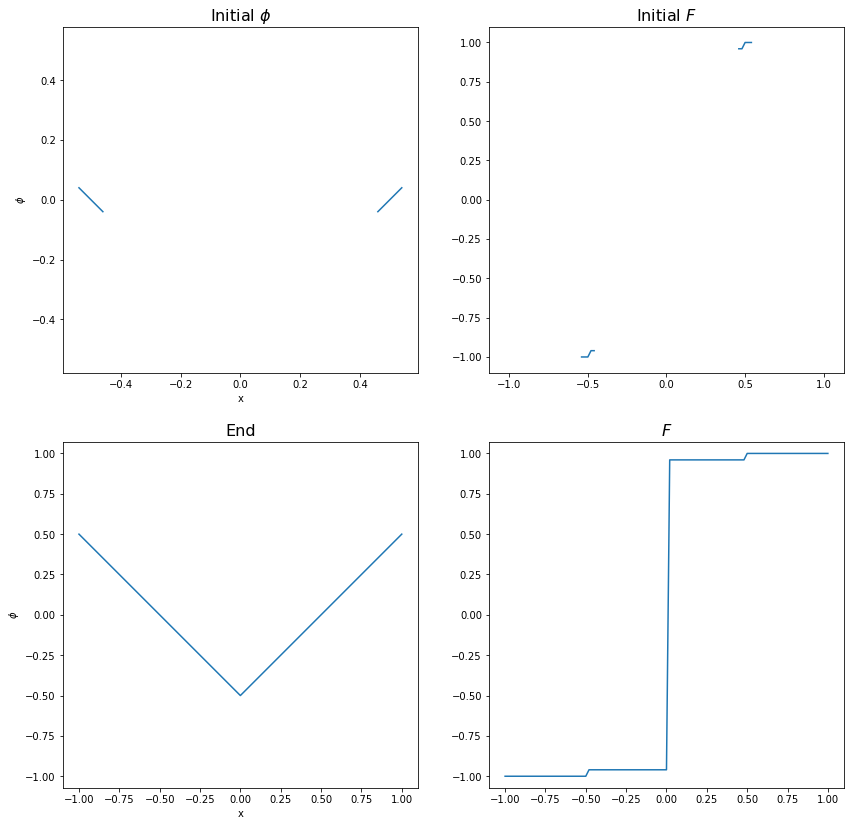

In [188]:
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
grid1D.plot(reinit1D.T)
plt.xlabel('x')
plt.ylabel('$\phi$')
plt.title('Initial $\phi$',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,2)
grid1D.plot(reinit1D.Fext[0])
plt.title('Initial $F$',fontsize=16)
plt.axis('equal')

reinit1D.loop(vstop=0.5)

plt.subplot(2,2,3)
grid1D.plot(reinit1D.T)
plt.xlabel('x')
plt.ylabel('$\phi$')
plt.title('End',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,4)
grid1D.plot(reinit1D.Fext[0])
plt.title('$F$',fontsize=16)
plt.axis('equal')

### 2D FMM

In [29]:
ch.setLevel(logging.WARN)

In [189]:
grid2D=GridHex(np.linspace(-1,1,101),np.linspace(-1,1,101))
phi=grid2D.X**2+grid2D.Y**2-0.25
xl=[(0.5*np.cos(theta),0.5*np.sin(theta)) for theta in np.linspace(0,2*np.pi,101)]
Fl=[[x for x,y in xl],[y for x,y in xl]]
reinit2D=ReinitializeFMM(grid2D,phi,extend={"xl":xl,"Fl":Fl})
#reinit2D.Fext=[reinit2D.grid.X.copy(),reinit2D.grid.Y.copy()]

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:292: RuntimeWarning: invalid value encountered in double_scalars


(-1.0, 1.0, -1.0, 1.0)

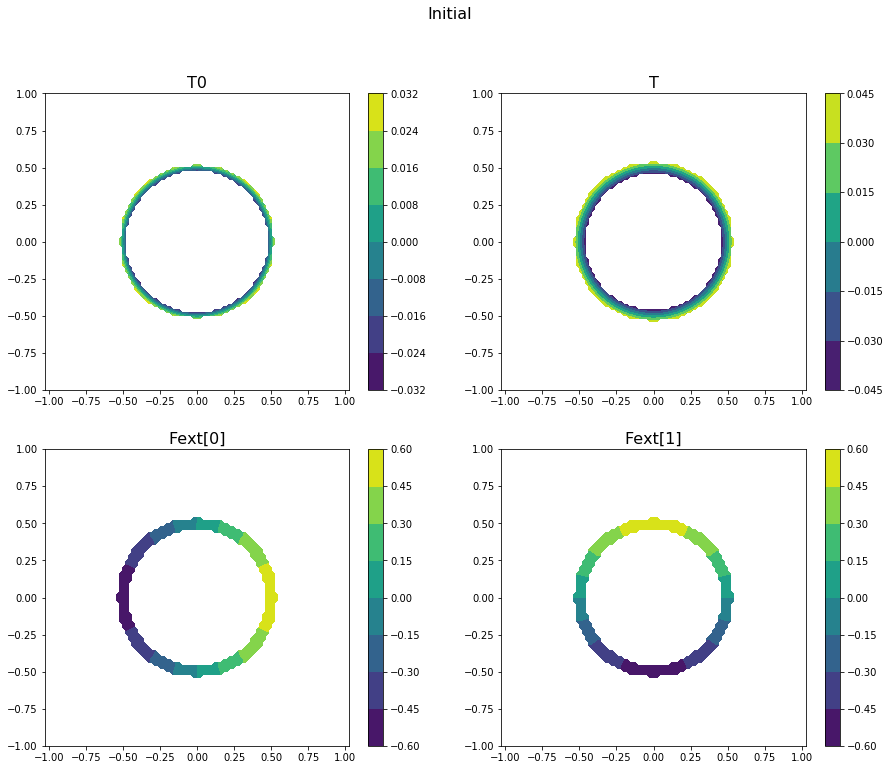

In [190]:
plt.figure(figsize=(15,12))
plt.suptitle('Initial',fontsize=16)
plt.subplot(2,2,1)
grid2D.plot(reinit2D.T0)
plt.title('T0',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,2)
grid2D.plot(reinit2D.T)
plt.title('T',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,3)
grid2D.plot(reinit2D.Fext[0])
plt.title('Fext[0]',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,4)
grid2D.plot(reinit2D.Fext[1])
plt.title('Fext[1]',fontsize=16)
plt.axis('equal')

In [191]:
%time reinit2D.loop(vstop=1.0)

Wall time: 14.2 s


(-1.0, 1.0, -1.0, 1.0)

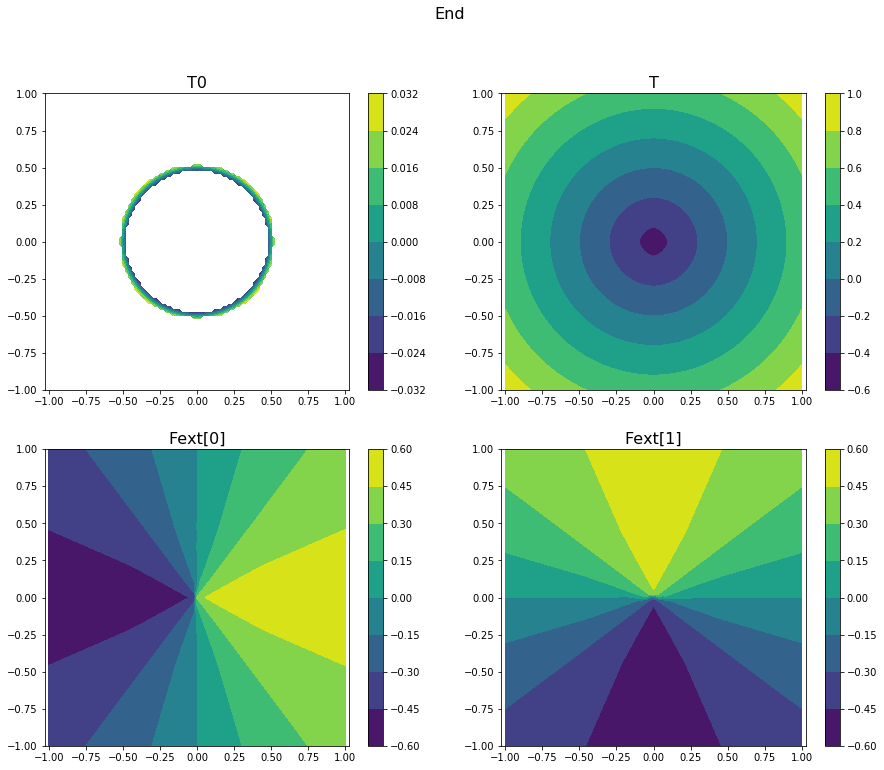

In [192]:
plt.figure(figsize=(15,12))
plt.suptitle('End',fontsize=16)
plt.subplot(2,2,1)
grid2D.plot(reinit2D.T0)
plt.title('T0',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,2)
grid2D.plot(reinit2D.T)
plt.title('T',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,3)
grid2D.plot(reinit2D.Fext[0])
plt.title('Fext[0]',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,4)
grid2D.plot(reinit2D.Fext[1])
plt.title('Fext[1]',fontsize=16)
plt.axis('equal')

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.9144046374270391

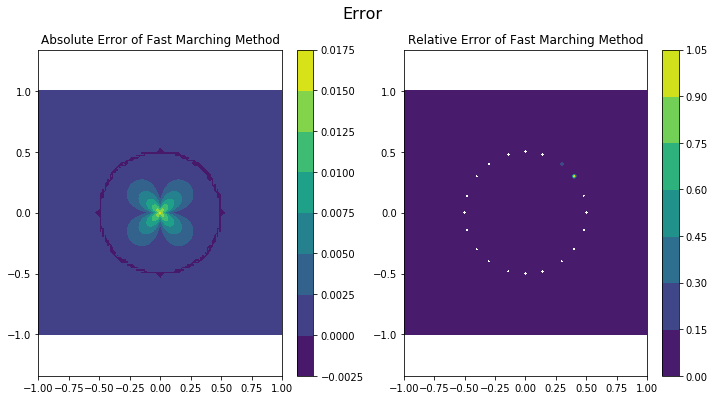

In [194]:
#reinit2D.loop(vstop=0.2)
plt.figure(figsize=(12,6))

plt.suptitle('Error',fontsize=16)
Z=reinit2D.T
Z0=np.sqrt(reinit2D.grid.X**2+reinit2D.grid.Y**2)-np.sqrt(0.25)
plt.subplot(1,2,1)
grid2D.plot(np.where(reinit2D.Status>=0,Z-Z0,np.inf),title='Absolute Error of Fast Marching Method')
plt.axis('equal')
plt.subplot(1,2,2)
grid2D.plot(np.where(reinit2D.Status>=0,np.abs((Z-Z0)/Z0),np.inf),title='Relative Error of Fast Marching Method')
plt.axis('equal')
np.amax(Z[reinit2D.Status==1])

### 3D FMM

In [600]:
grid3D=GridHex(np.linspace(-1,1,21),np.linspace(-1,1,21),np.linspace(-1,1,21))
phi=grid3D.X**2+grid3D.Y**2+grid3D.Z**2-3*0.5**2
reinit3D=ReinitializeFMM(grid3D,phi)

[-0.25 -0.14 -0.18 -0.07 -0.16 -0.05 -0.09  0.02]
[0.40000000000000013, 0.30000000000000004, 0.5] (-0.2499999999999999, (0.8000000000000003, 0.6000000000000008, 0.9999999999999999))
[0.40000000000000013, 0.30000000000000004, 0.6000000000000001] (-0.13999999999999974, (0.8000000000000003, 0.6000000000000008, 1.2000000000000026))
[0.40000000000000013, 0.40000000000000013, 0.5] (-0.17999999999999972, (0.8000000000000003, 0.8000000000000003, 1.0000000000000009))
[0.40000000000000013, 0.40000000000000013, 0.6000000000000001] (-0.06999999999999978, (0.8000000000000003, 0.7999999999999967, 1.1999999999999988))
[0.5, 0.30000000000000004, 0.5] (-0.15999999999999992, (1.0000000000000002, 0.6000000000000008, 1.0000000000000009))
[0.5, 0.30000000000000004, 0.6000000000000001] (-0.05000000000000002, (0.999999999999995, 0.6000000000000011, 1.199999999999997))
[0.5, 0.40000000000000013, 0.5] (-0.08999999999999994, (0.9999999999999978, 0.7999999999999984, 1.0000000000000004))
[0.5, 0.40000000000000013

### 裂纹扩展

In [238]:
fmmlogger.handlers[0].setLevel(logging.WARN)

In [330]:
Nx,Ny=101,101
grid=GridHex(np.linspace(-1,1,Nx),np.linspace(-1,1,Ny))
index=(0,0)
X=np.full_like(grid.X,np.inf)
status=np.full((Nx,Ny),-1,dtype=np.int8)

theta=np.pi/4
cet=np.array([(seed[ind]+seed[ind+1])/2 for seed,ind in zip(grid.seeds,index)])
for i,j in product(*[range(4) for _ in range(2)]):
    ind1,ind2=index[0]+i,index[1]+j
    status[ind1,ind2]=1
    crd=np.array([seed[ind] for seed,ind in zip(grid.seeds,(ind1,ind2))])
    X[ind1,ind2]=np.dot(crd-cet,np.array([np.cos(theta),np.sin(theta)]))

fmm=ReinitializeFMM(grid,X)

In [267]:
fmm.loop(vstop=1.0)

(-1.0, 1.0, -1.0, 1.0)

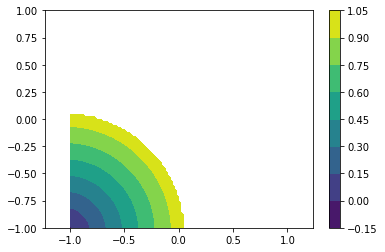

In [268]:
#plt.figure(figsize=(5,5))
grid.plot(fmm.T)
plt.axis('equal')

In [242]:
fmm.T[:4,:4]

array([[-0.01414214,  0.        ,  0.01407126,  0.02814217],
       [ 0.        ,  0.01414213,  0.02828427,  0.04235518],
       [ 0.01407126,  0.02828427,  0.04242641,  0.05653288],
       [ 0.02814217,  0.04235518,  0.05653288,  0.07067502]])

In [243]:
np.sum(fmm.Status==0)

73

### 直裂纹

In [325]:
fmmlogger.handlers[0].setLevel(logging.WARN)

In [337]:
grid=GridHex(np.linspace(-1,1,11),np.linspace(-1,1,11))
exact=grid.Y-0.3
accept=np.logical_and(np.abs(exact)<=(2*2/(11-1)+1e-6),grid.X<0.3)
fmm=FastMarching(grid,np.where(accept,exact,np.infty),status=accept,V=1.0)

(-1.0, 1.0, -1.0, 1.0)

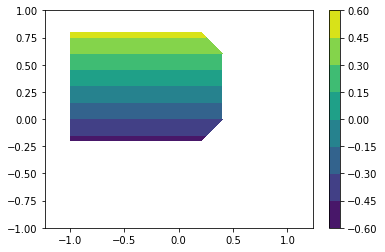

In [338]:
fmm.grid.plot(fmm.T)
plt.axis('equal')

In [324]:
fmm.dervCoff((7,6))

([[-1, 5.000000000000001, 0.49999999999999917, 0.19999999999999996, inf],
  [0, 0, 0, inf, inf]],
 (-0.09999999999999981, 0.0))

In [340]:
fmm.loop(vstop=1.0)

(-1.0, 1.0, -1.0, 1.0)

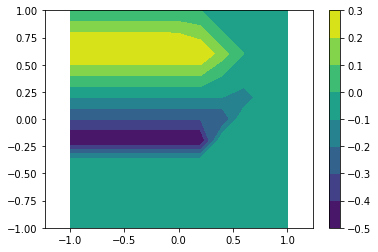

In [341]:
fmm.grid.plot(fmm.T)
plt.axis('equal')

### 圆裂纹

In [178]:
grid=GridHex(np.linspace(-1,1,101),np.linspace(-1,1,101))
exact=np.sqrt(grid.X**2+grid.Y**2)-0.5
accept=exact<=0.15
T=np.where(accept,exact,np.infty)
status=np.where(accept,1,-1)
fmm=FastMarching(grid,T,status=status)

In [179]:
fmm.loop(vstop=0.3)

(-1.0, 1.0, -1.0, 1.0)

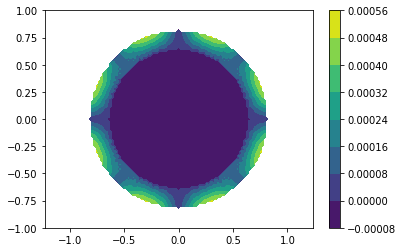

In [182]:
fmm.grid.plot(fmm.T-exact)
plt.axis('equal')

### 折线裂纹

In [686]:
fmmlogger.handlers[0].setLevel(logging.WARN)

In [ ]:
4181

In [341]:
grid=GridHex(np.linspace(-1,1,11),np.linspace(-1,1,11))
phi,psi=np.where(grid.X<=-0.1,(grid.X+grid.Y+0.1)/np.sqrt(2),grid.Y),grid.X
accept=np.abs(phi)<0.2
fmm=ReinitializeFMM(grid,phi)

2020-04-21 23:00:43,413 - FastMarching - WARNING - cubic distance while loop than 100 times [-0.2 -0.2] -> [-0.09479925  0.02862071]


In [342]:
%time fmm.loop(vstop=1.0)

Wall time: 91.9 ms


In [340]:
np.amin(fmm.T)

-1.3637320019866095

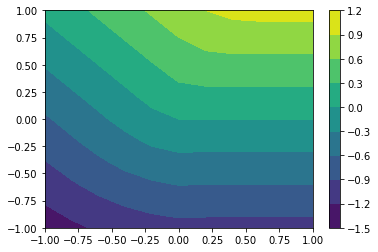

In [343]:
grid.plot(fmm.T)

In [ ]:
fmm3D_logger=logging.getLogger('FMM3D')
fmm3D_logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.WARN)
ch.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
fmm3D_logger.handlers.clear()
fmm3D_logger.addHandler(ch)

In [566]:
logging.getLogger("FMM3D").handlers

[<StreamHandler stderr (WARNING)>]

In [ ]:
# -*- coding: UTF-8 -*-

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from itertools import product
import logging

#from FastMarching import FastMarching,ReinitializeFMM

fmm3D_logger=logging.getLogger('FMM3D')
fmm3D_logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.WARN)
ch.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
fmm3D_logger.handlers.clear()
fmm3D_logger.addHandler(ch)

In [571]:
class Crack3D_FMM:
    """
    1. Bærentzen J A. On the implementation of fast marching methods for 3D lattices[J]. 2001.
    2. Sukumar N, Chopp D L, Moran B. Extended finite element method and fast marching method for three-dimensional fatigue crack propagation[J]. Engineering Fracture Mechanics, 2003, 70(1): 29-48.
    3. Sethian J A. Fast marching methods[J]. SIAM review, 1999, 41(2): 199-235.    
    4. Sukumar N, Chopp D L, Bechet E, et al. Three‐dimensional non‐planar crack growth by a coupled extended finite element and fast marching method[J]. International Journal for Numerical Methods in Engineering, 2008, 76(5): 727-748.
    5. Chopp D L. Some improvements of the fast marching method[J]. SIAM Journal on Scientific Computing, 2001, 23(1): 230-244.
        Give the detail for 2D case
    6. Shi J, Chopp D, Lua J, et al. Abaqus implementation of extended finite element method using a level set representation for three-dimensional fatigue crack growth and life predictions[J]. Engineering Fracture Mechanics, 2010, 77(14): 2840-2863.
        Give the detail for 3D case
    7. Adalsteinsson D , Sethian J A . The Fast Construction of Extension Velocities in Level Set Methods[J]. Journal of Computational Physics, 1999, 148(1):2-22.
    """
    def __init__(self,grid,phi0,psi0,extend=None,Fext=[]):
        self.logger=logging.getLogger("FMM3D")
        
        self.grid=grid
        self.phi0=phi0
        self.phi=phi0.copy()
        self.psi0=psi0
        self.psi=psi0.copy()

        # used in Reintialization to 
        if extend is None:
            xl,Fl=[],[]
        else:
            xl,Fl=extend['xl'],extend['Fl']
        
    def advanceFront(self,xl,Fl):
        grid=self.grid
        phi,psi=self.phi,self.psi
        
        status,rho,Fext=self.frontInitialize(grid,phi,psi,xl,Fl)
        
        self.logger.info("Start Compute the distance to the crack front and  Extend the tip velocity")
        reinit=FastMarching(grid,rho,status,V=1.0,Fext=Fext)
        vstop=6*max(np.max(seed[1:]-seed[:-1]) for seed in grid.seeds)
        reinit.loop(vstop=vstop)
        self.logger.info("End! ")
        
        rho,Fext=self.reinit.T,self.reinit.Fext
        
        grad_rho=np.gradient(rho,grid.seeds)
        normG=np.sqrt(grad_rho[0]*grad_rho[0]+grad_rho[1]*grad_rho[1]+grad_rho[2]*grad_rho[2])
        normF=np.sqrt(Fext[0]*Fext[0]+Fext[1]*Fext[1]+Fext[2]*Fext[2])
        
        psi1=rho*(grad_rho[0]*Fext[0]+grad_rho[1]*Fext[1]+grad_rho[2]*Fext[2])/(normG*normF)
        
        phi1=np.where(np.logical_and(psi<=0,psi1<=0),phi,)
        
    def frontInitialize(self,grid,phi,psi,xl,Fl):
        """
        compute 
            1. the distance to the crack front using tricubic approximation 
            2. the velocity vector interpolate from the velocity vector `Fl` at crack front `xl`
        for those grid points near the crack front (cut by crack front)

        Tip Velocity Extension
            Ref.1 Section 3.3
            Ref.3 Section 3.1.2
            Ref.4 
        the front velocity data are provided as a list of sample coordinates, Xl , and the corresponding front velocity vector, Fl.
          search for the two sample coordinates xl1 and xl2 closest to x,
          F_{ijk} =(1−\alpha)F_{l1} +\alpha F_{l2 }            

        """
        ndim=grid.ndim
        
        status=np.full(grid.shape,-1)
        rho=np.full(grid.shape,np.inf)
        Fext=[np.full(grid.shape,np.inf) for _ in range(len(Fl))]
        
        extend=(len(Fl)>0)

        for vindex in product(*[range(grid.shape[i]-1) for i in range(ndim)]):
            if grid.isSignChange(vindex,phi) and grid.isSignChange(vindex,psi):
                cofp=grid.cubicCoff(vindex,phi)
                cofq=grid.cubicCoff(vindex,psi)
                for point in grid.voxelPoints(vindex):
                    status[point]=1
                    d=self.cubicDistance(grid,phi,psi,vindex,cofp,cofq,grid.coord(point))
                    rho[point]=min(d,rho[point])
                    if extend:
                        x=grid.coord(point)
                        i1,x1,d1=None,None,np.infty
                        i2,x2,d2=None,None,np.infty
                        for i,pt in enumerate(xl):
                            d=sum(((x[j]-pt[j])**2 for j in range(len(x))))**0.5
                            if d<d1:
                                i2,x2,d2=i1,x1,d1
                                i1,x1,d1=i,pt,d
                            elif d<d2:
                                i2,x2,d2=i,pt,d
                        
                        a=sum(((x[j]-x1[j])**2 for j in range(len(x))))
                        b=sum(((x[j]-x2[j])**2 for j in range(len(x))))
                        c=sum(((x[j]-x1[j])*(x[j]-x2[j]) for j in range(len(x))))
                        # (1-alpha)*x1+alpha*x2 is the closet 
                        alpha=min(1,max(0,(a-c)/(a+b-2*c)))
                        for i in range(len(Fext)):
                            Fext[i][point]=(1-alpha)*Fl[i][i1]+alpha*Fl[i][i2]
                        self.logger.debug("index=%s,x=%s,x1=%s,x2=%s,alpha=%f,a=%f,b=%f,c=%f"%(repr(point),repr(x),repr(x1),repr(x2),alpha,a,b,c))

        return status,rho,Fext

    def cubicDistance(self,grid,phi,psi,vindex,cofp,cofq,xs):
        """
        Modified Newton Method for cubic interpolation 
        introduced in 

        """
        ndim=grid.ndim
        
        x0,x=np.array(xs),np.array(xs)
        bnds=grid.voxelBound(vindex)
        vol=np.prod([bnd[1]-bnd[0] for bnd in bnds])
        
        cnt=0
        while True:
            # 是否在外部
            inside,index1=True,[]
            for i in range(ndim):
                inc=0 
                if x[i]<bnds[i][0]-1e-7:
                    inc,inside=-1,False
                elif x[i]>bnds[i][1]+1e-7:
                    inc,inside=1,False
                index1.append(vindex[i]+inc)
            
            if inside:
                p,derv_p=grid.cubicInterpolation(cofp,vindex,x)
                q,derv_q=grid.cubicInterpolation(cofq,vindex,x)
            else:
                cofp1=grid.cubicCoff(index1,phi)
                cofq1=grid.cubicCoff(index1,psi)
                p,derv_p=grid.cubicInterpolation(cofp1,vindex,x)
                q,derv_q=grid.cubicInterpolation(cofq1,vindex,x)
                self.logger.info('iteration go out side the voxel')
            derv_p=np.array(derv_p)
            derv_q=np.array(derv_q)
            
            derv=p*derv_p+q*derv_q
            sqr=np.dot(derv,derv)
            
            dlt1=-(p**2+q**2)/sqr*derv
            dlt1[np.isnan(dlt1)]=0.
            
            derv=np.cross(derv_p,derv_q)
            sqr=np.dot(derv,derv)
            dlt2=np.dot(x0-x,derv)/sqr*derv
            dlt2[np.isnan(dlt2)]=0.
            #print(x0,x,f,derv,dlt1,dlt2)
            
            x=x+dlt1+dlt2
            cnt=cnt+1
            #self.logger.debug("x=%s;p=%f;q=%f;derv_p=%s;derv_q=%s;dlt1=%s;dlt2=%s"%(repr(x),p,q,repr(derv_p),repr(derv_q),repr(dlt1),repr(dlt2)))
            if(np.linalg.norm(dlt1+dlt2)<(1e-3*vol)):
                return np.linalg.norm(x-x0)
            if cnt>20:
                self.logger.warning('cubic distance while loop than 20 times %s -> %s'%(x0,x))
                return np.linalg.norm(x-x0)
        
    def extendVelocity(self,xl,Fl):
        pass
    
    def velocity(self,index):
        raise NotImplementedError('Velocity not implemented!')
    
    @staticmethod
    def smearedSign(Z,sgnfactor):
        return Z/np.sqrt(Z**2+sgnfactor**2)

    @staticmethod
    def minabs(A,B):
        """
        (2007)Antoine du Chéné, Chohong Min, Frédéric Gibou. Second-Order Accurate Computation of Curvatures in a Level Set Framework Using Novel High-Order Reinitialization Schemes(2007)Antoine du Chéné, Chohong Min, Frédéric Gibou. Second-Order Accurate Computation of Curvatures in a Level Set Framework Using Novel High-Order Reinitialization Schemes
        >>> minabs(-1,-2),minabs(1,-2),minabs(-1,2),minabs(1,2)
        """
        return np.where(abs(A)<abs(B),A,B)

    @staticmethod
    def minmod(A,B):
        """
        (2007)Antoine du Chéné, Chohong Min, Frédéric Gibou. Second-Order Accurate Computation of Curvatures in a Level Set Framework Using Novel High-Order Reinitialization Schemes
        >>> minmod(np.linspace(0,1,11),-0.5),minmod(np.linspace(0,1,11),0.5)
        """
        mask1=(A*B)>0
        mask2=abs(A)>abs(B)
        return B*np.logical_and(mask1,mask2)+A*np.logical_and(mask1,np.logical_not(mask2))
        

In [568]:
ch.setLevel(logging.WARN)

In [575]:
grid=GridHex(np.linspace(-1,1,21),np.linspace(-1,1,21),np.linspace(-1,1,21))
phi0=grid.Y-0.3
psi0=grid.X-0.0
crack=Crack3D_FMM(grid,phi0,psi0)

In [576]:
xl=[(0,0.3,x) for x in np.linspace(-1,1,21)]
Fl=[[1.0 for x in xl],
    [2.0 for x in xl],
    [0.0 for x in xl]]

%time status,rho,Fext=crack.frontInitialize(grid,phi0,psi0,xl,Fl)
reinit=FastMarching(grid,rho,status,V=1.0,Fext=Fext)
vstop=np.inf #6*max(np.max(seed[1:]-seed[:-1]) for seed in grid.seeds)
%time reinit.loop(vstop=vstop)
rho,Fext=reinit.T,reinit.Fext

Wall time: 609 ms
Wall time: 3.95 s


In [579]:
grad_phi=np.gradient(rho,*grid.seeds)

normG=np.sqrt(grad_phi[0]*grad_phi[0]+grad_phi[1]*grad_phi[1]+grad_phi[2]*grad_phi[2])
normF=np.sqrt(Fext[0]*Fext[0]+Fext[1]*Fext[1]+Fext[2]*Fext[2])
phi2=rho*(grad_phi[0]*Fext[0]+grad_phi[1]*Fext[1]+grad_phi[2]*Fext[2])/(normG*normF)

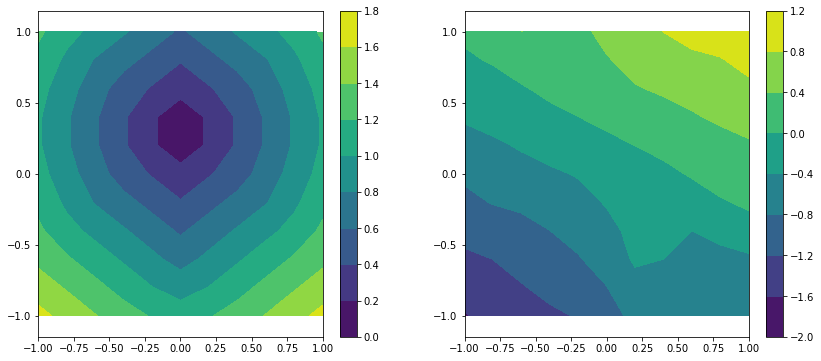

In [580]:
slc=(slice(None),slice(None),5)
plt.figure(figsize=(14,6))
plt.subplot('121')
plt.contourf(grid.X[slc],grid.Y[slc],rho[slc])
plt.axis('equal')
plt.colorbar()
plt.subplot('122')
plt.contourf(grid.X[slc],grid.Y[slc],phi2[slc])
plt.axis('equal')
plt.colorbar()

AttributeError: 'Crack3D_FMM' object has no attribute 'reinit'

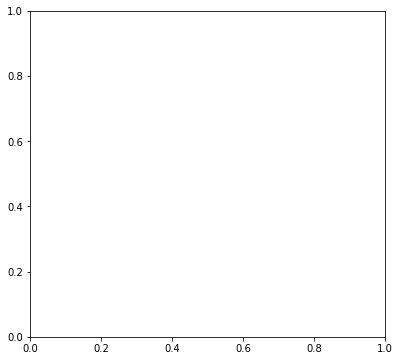

In [496]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
X,Y=crack.grid.X[:,:,5],crack.grid.Y[:,:,5]
plt.contourf(X,Y,crack.reinit.T[:,:,5])
plt.axis('equal')
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(X,Y,crack.reinit.Fext[0][:,:,0])
plt.axis('equal')
plt.colorbar()

In [392]:
x,y,z=np.linspace(-1,1,6),np.linspace(-1,1,6),np.linspace(-1,1,6)
np.gradient()

In [377]:
crack.reinit.T-np.sqrt(crack.grid.X**2+(crack.grid.Y-0.3)**2+crack.grid.Z**2)

array([[[-0.25966092, -0.1684686 , -0.08655419, ..., -0.08501559, -0.16341942, -0.25952794],
        [-0.28758716, -0.18522019, -0.0994966 , ..., -0.09894346, -0.18401581, -0.28746879],
        [-0.32935783, -0.21559556, -0.12570954, ..., -0.12614434, -0.21829993, -0.32935781],
        ...,
        [-0.37599266, -0.24560408, -0.13446889, ..., -0.13446889, -0.24560408, -0.37599266],
        [-0.35824416, -0.23301687, -0.12710191, ..., -0.1271002 , -0.23301691, -0.35824416],
        [-0.34253707, -0.22401564, -0.12471074, ..., -0.12463631, -0.22401471, -0.34253707]],

       [[-0.27953538, -0.19324771, -0.10500049, ..., -0.10231869, -0.18556554, -0.2870255 ],
        [-0.30775408, -0.20334537, -0.10776286, ..., -0.10603446, -0.19740097, -0.30762189],
        [-0.34204716, -0.22442523, -0.12276408, ..., -0.12202083, -0.22234166, -0.34190601],
        ...,
        [-0.43836204, -0.29353738, -0.16709804, ..., -0.16709804, -0.29353738, -0.43836204],
        [-0.41509904, -0.27725802, -0.1583